In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
# import warnings
# warnings.filterwarnings("ignore")

# Reading Data

In [9]:
df_chunk = pd.read_csv('train.csv', chunksize = 500000, low_memory = False)
chunks = []

In [10]:
coord_list = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']
def remove_invalid(chunk):
    for c in coord_list:
        for i in chunk.index:
            if(c == "pickup_longitude" or c == "dropoff_longitude"):
                if(chunk[c][i].astype(float) > -73.699215 or chunk[c][i].astype(float) < -74.257159):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
                    chunk = chunk.drop([i])
            elif (c == "pickup_latitude" or c == "dropoff_latitude"):
                if(chunk[c][i].astype(float) > 40.915568 or chunk[c][i].astype(float) < 40.495992):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
                    chunk = chunk.drop([i])
            elif(c == "fare_amount"):
                if(chunk[c][i] >= 200 or chunk[c][i] <= 0):
                    chunk = chunk.drop([i])
    return chunk
        

In [1]:
def remove_outlier(chunk, data_1):
    outliers_indices=[]
    threshold = 3
    mean_1 = np.mean(data_1)
    std_1 = np.std(data_1)
    
#     length = len(data_1)
    for i in chunk.index:
        z_score= (data_1[i] - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers_indices.append(i)
    for i in outliers_indices:
        chunk = chunk.drop([i])
    return chunk


# print(len(detect_outlier(chunks[1]['fare_amount'])))

In [12]:
def split_datetime(chunk):
    hours = []
    mins = []
    secs = []
    years = []
    months = []
    days = []
    length = len(chunk['pickup_longitude'])
    
    for i in chunk.index:
        years.append(int(chunk['pickup_datetime'][i][0:4]))
        months.append(int(chunk['pickup_datetime'][i][5:7]) - 1) # 1 is subtracted to aid in days from jan 1st calculations
        days.append(int(chunk['pickup_datetime'][i][8:10]))
        hours.append(int(chunk['pickup_datetime'][i][11:13]))
        mins.append(int(chunk['pickup_datetime'][i][14:16]))
        secs.append(int(chunk['pickup_datetime'][i][17:19]))

    chunk['years'] = years
    chunk['months'] = months
    chunk['days'] = days
    chunk['hours'] = hours
    chunk['mins'] = mins
    chunk['secs'] = secs
    
    return chunk

In [13]:
def modify_datetime(chunk):
    chunk['secs_past_midnight'] = (chunk['hours']*3600) + (chunk['mins']*60) + (chunk['secs'])
    chunk['sin_spm'] = np.sin(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['cos_spm'] = np.cos(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['days_past_jan1'] = (chunk['months']*30) + (chunk['days'])
    chunk['sin_dpj'] = np.sin(2*np.pi*(chunk['days_past_jan1']/365))
    chunk['cos_dpj'] = np.cos(2*np.pi*(chunk['days_past_jan1']/365))
    
    return chunk

In [14]:
def split_data(chunk):
    y = chunk['fare_amount']
    X = pd.DataFrame(chunk)
    X = X.drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
    X = StandardScaler().fit_transform(X)
    return (X, y)

In [15]:
def linreg(X, y, linreg = LinearRegression()):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
#     linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return (linreg, rmse)

# X1_train, X1_test, y1_train, y1_test = train_test_split(features, target, random_state=1)

In [16]:
def save_model(model, filename): 
#     filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [17]:
def load_model(filename): 
    model = pickle.load(open(filename, 'rb'))
    return model

# Reading chunks and applying functions

In [ ]:
count = 0
for chunk in df_chunk:
    if (count == 0):
        model = LinearRegression()
#     else:
#         model = load_model("model.sav")
        
    chunk = remove_invalid(chunk)
    chunk.dropna(inplace = True)
    chunk = split_datetime(chunk)
    chunk = modify_datetime(chunk)
    chunk = remove_outlier(chunk, chunk['fare_amount'])
    chunk['manhattan_dist'] = abs(chunk['pickup_latitude']-chunk['dropoff_latitude']) + abs(chunk['pickup_longitude']-chunk['dropoff_longitude'])
    (X1, y1) = split_data(chunk)
    model, rmse = linreg(X1, y1, model)
#     save_model(model, "model.sav")
    print(rmse)
    
    if (count == 0):
        chunks.append(pd.DataFrame(chunk))
    count += 1
    if(count == 4):
        break

# Visualization plots 

AxesSubplot(0.125,0.125;0.775x0.755)


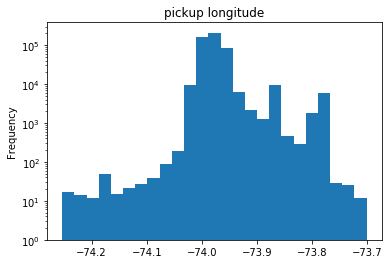

In [13]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_longitude"].plot.hist(ax = ax, title="pickup longitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


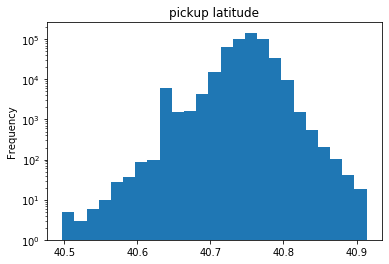

In [14]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_latitude"].plot.hist(ax = ax, title="pickup latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


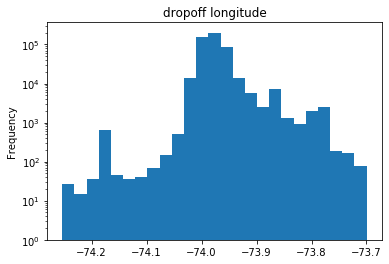

In [15]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_longitude"].plot.hist(ax = ax, title="dropoff longitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


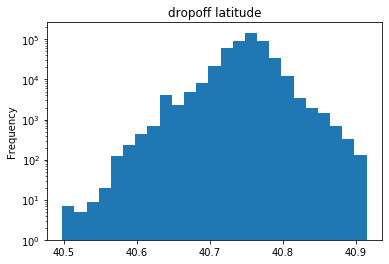

In [16]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_latitude"].plot.hist(ax = ax, title="dropoff latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


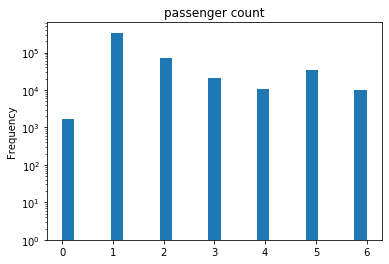

In [17]:
fig, ax = plt.subplots()
print(chunks[0]["passenger_count"].plot.hist(ax = ax, title="passenger count",bottom=1, bins=25))
ax.set_yscale('log')

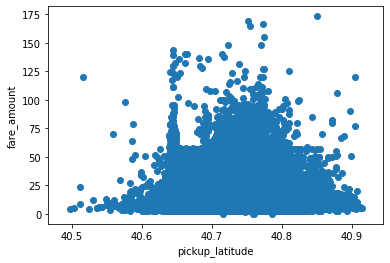

In [18]:
plt.scatter(chunks[0]["pickup_latitude"],chunks[0]["fare_amount"])
plt.xlabel("pickup_latitude")
plt.ylabel("fare_amount")
plt.show()

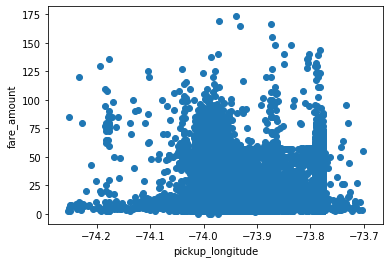

In [19]:
# fig, ax = plt.subplots()

plt.scatter(chunks[0]["pickup_longitude"],chunks[0]["fare_amount"])
plt.xlabel("pickup_longitude")
plt.ylabel("fare_amount")
plt.show()

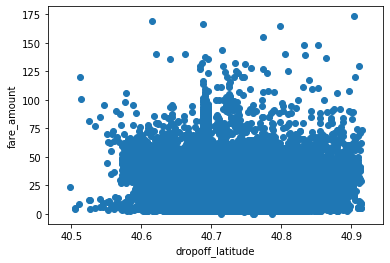

In [106]:
plt.scatter(chunks[0]["dropoff_latitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_latitude")
plt.ylabel("fare_amount")
plt.show()

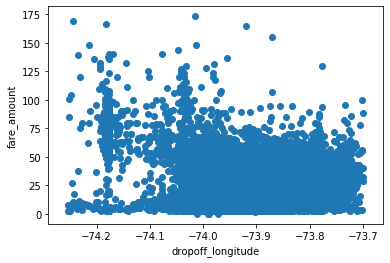

In [107]:
plt.scatter(chunks[0]["dropoff_longitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_longitude")
plt.ylabel("fare_amount")
plt.show()

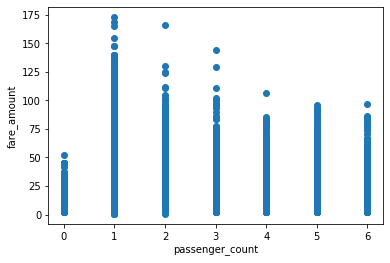

In [108]:
plt.scatter(chunks[0]["passenger_count"],chunks[0]["fare_amount"])
plt.xlabel("passenger_count")
plt.ylabel("fare_amount")
plt.show()

# Detecting Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff6e5cfb9b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff6e5ce77f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff6e5cfb7b8>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff6e5d138d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff6e5d13e10>],
 'means': []}

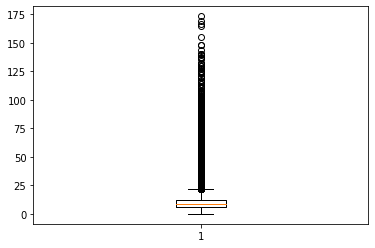

In [126]:
plt.boxplot(chunks[0].fare_amount)

In [10]:
chunks[0].to_csv('preprocessed.csv')
chunk1 = pd.read_csv('preprocessed.csv')
chunks.append(chunk1)
chunks[1].head()
chunks[0].describe()

In [24]:
# indices = detect_outlier(chunks[1]['fare_amount'])
# for i in indices:
#     chunks[1] = chunks[1].drop([i])
#     print(i)

63
124
212
227
259
293
294
308
322
333
337
422
441
447
454
465
535
667
683
725
880
882
908
931
951
1039
1042
1091
1120
1237
1253
1254
1312
1347
1399
1411
1419
1422
1423
1458
1468
1517
1560
1577
1615
1616
1623
1628
1656
1665
1700
1719
1759
1804
1822
1869
1875
1914
1922
1942
2044
2096
2112
2135
2137
2138
2148
2162
2184
2217
2247
2283
2302
2313
2325
2408
2479
2482
2545
2552
2607
2625
2661
2663
2704
2715
2724
2751
2791
2958
2971
3124
3385
3432
3443
3505
3524
3559
3584
3644
3730
3758
3798
3802
3907
3912
4006
4034
4044
4079
4118
4140
4178
4185
4236
4337
4353
4355
4362
4380
4384
4406
4420
4454
4491
4500
4503
4539
4540
4549
4590
4603
4611
4614
4672
4711
4763
4790
4805
4808
4818
4865
4927
4944
4951
4972
5028
5085
5131
5135
5198
5216
5230
5265
5269
5278
5293
5303
5366
5444
5455
5467
5511
5529
5565
5587
5597
5609
5675
5686
5732
5772
5851
5875
5894
6002
6019
6118
6162
6202
6221
6240
6384
6411
6437
6506
6554
6580
6629
6688
6730
6784
6801
6803
6882
6895
6914
6954
6993
7049
7078
7088
7115
7120
7156
7

50075
50199
50252
50272
50310
50340
50441
50446
50474
50529
50552
50555
50557
50587
50665
50680
50694
50734
50737
50741
50782
50820
50938
51031
51071
51194
51217
51241
51289
51346
51411
51462
51559
51584
51611
51649
51766
51778
51814
51929
51944
51969
52020
52175
52188
52189
52204
52258
52304
52312
52331
52351
52387
52392
52418
52490
52511
52705
52762
52767
52769
52920
52950
52985
53059
53072
53090
53121
53182
53190
53197
53314
53318
53342
53360
53365
53369
53458
53510
53539
53540
53600
53621
53651
53654
53705
53745
53773
53809
53921
53952
53980
53982
53986
54044
54049
54088
54099
54121
54127
54128
54132
54220
54229
54248
54291
54347
54369
54378
54379
54427
54428
54608
54688
54696
54794
54797
54894
54910
54975
54997
55073
55100
55235
55236
55260
55280
55304
55351
55415
55461
55509
55540
55563
55569
55659
55676
55708
55737
55752
55790
55806
55809
55862
56040
56063
56145
56152
56232
56298
56366
56414
56418
56431
56452
56454
56464
56540
56552
56575
56606
56614
56623
56627
56667
56698
5673

99631
99691
99715
99742
99778
99783
99787
99861
99874
99952
100027
100066
100077
100104
100110
100134
100147
100223
100229
100237
100239
100245
100304
100359
100374
100393
100416
100446
100460
100489
100492
100520
100534
100554
100559
100610
100642
100687
100757
100774
100776
100794
100845
100849
100870
100910
100979
100997
101009
101052
101062
101175
101190
101363
101398
101400
101409
101437
101465
101527
101554
101603
101618
101619
101632
101685
101693
101733
101791
101802
101812
101825
101863
101922
101968
101977
102000
102025
102085
102096
102097
102226
102270
102274
102328
102340
102365
102440
102455
102495
102502
102505
102531
102587
102619
102640
102695
102700
102816
102888
102929
102995
103075
103114
103121
103146
103217
103244
103245
103258
103384
103414
103496
103525
103570
103657
103742
103768
103782
103809
103825
103858
103874
103934
103995
104011
104046
104053
104073
104093
104095
104104
104119
104175
104233
104383
104387
104400
104416
104417
104700
104732
104760
104770
10

141713
141723
141810
141815
141829
141843
141879
142080
142083
142099
142101
142131
142193
142206
142222
142232
142269
142348
142349
142393
142426
142491
142524
142536
142566
142580
142619
142638
142664
142703
142712
142760
142775
142791
142800
142874
142881
142917
142967
143000
143001
143050
143145
143162
143196
143247
143274
143390
143406
143410
143479
143496
143597
143753
143812
143826
143836
143846
143857
143866
143898
143905
143919
143934
143996
144000
144011
144050
144089
144103
144135
144160
144210
144229
144299
144312
144378
144406
144426
144445
144475
144572
144586
144601
144621
144628
144661
144745
144814
144878
144944
145014
145016
145019
145035
145060
145076
145161
145183
145187
145227
145259
145265
145338
145379
145383
145526
145537
145597
145598
145688
145704
145710
145745
145779
145790
145954
145971
145988
145990
146050
146089
146111
146119
146130
146161
146163
146197
146238
146257
146274
146288
146315
146360
146433
146452
146488
146519
146532
146560
146573
146587
146621

182256
182271
182315
182330
182467
182510
182516
182542
182643
182649
182657
182669
182708
182752
182836
182853
182948
182954
182995
183005
183031
183142
183149
183188
183189
183225
183264
183350
183402
183448
183533
183585
183593
183610
183618
183644
183723
183727
183777
183847
183850
183894
183905
183979
183993
184050
184127
184138
184178
184187
184201
184231
184279
184334
184406
184431
184433
184453
184528
184561
184563
184570
184608
184617
184667
184671
184704
184716
184766
184767
184773
184779
184826
184888
184895
184930
185018
185029
185048
185068
185117
185165
185243
185278
185308
185337
185514
185545
185550
185606
185626
185652
185666
185683
185689
185722
185756
185766
185786
185886
185906
185937
185947
185970
186008
186013
186064
186077
186090
186117
186168
186193
186213
186244
186275
186283
186312
186335
186343
186363
186376
186449
186450
186462
186518
186552
186564
186567
186609
186617
186730
186881
186883
186951
186954
186955
186963
186971
186974
186988
187001
187002
187007

223750
223759
223789
223825
223839
223854
223951
223970
223990
224032
224127
224184
224190
224428
224437
224463
224477
224511
224567
224578
224598
224642
224786
224841
224878
224882
224910
224914
224917
224943
224963
224970
225017
225124
225125
225143
225205
225229
225324
225350
225386
225389
225415
225423
225437
225438
225564
225594
225611
225613
225622
225625
225630
225656
225662
225670
225685
225704
225712
225822
225833
225850
225875
225886
225906
225951
225970
225978
226056
226075
226154
226177
226204
226245
226266
226292
226296
226457
226464
226592
226611
226642
226749
226751
226807
226851
227075
227106
227199
227259
227380
227474
227476
227509
227562
227608
227622
227705
227757
227793
227794
227852
227860
227879
227946
227955
227990
228027
228046
228131
228143
228203
228263
228284
228319
228361
228392
228439
228446
228527
228598
228614
228644
228651
228668
228707
228712
228713
228776
228784
228807
228846
228886
228904
228909
228974
228980
229012
229034
229062
229102
229104
229115

267784
267795
267871
267893
267968
268011
268119
268135
268272
268287
268346
268362
268454
268523
268549
268566
268606
268668
268746
268751
268779
268855
268891
268972
268995
269058
269071
269077
269115
269131
269136
269210
269221
269237
269301
269336
269390
269407
269428
269496
269522
269527
269540
269609
269616
269637
269663
269689
269735
269754
269846
269857
269863
269885
269966
269978
270101
270112
270116
270137
270280
270295
270394
270438
270444
270497
270560
270586
270596
270635
270644
270712
270907
270952
270981
270986
271001
271040
271060
271113
271124
271164
271189
271204
271236
271279
271281
271320
271406
271440
271530
271564
271579
271590
271600
271642
271652
271668
271700
271715
271756
271788
271796
271803
271829
271859
271878
271907
271911
271925
271987
271996
272115
272159
272195
272208
272215
272218
272245
272253
272293
272493
272512
272582
272604
272636
272637
272647
272658
272667
272678
272690
272703
272750
272754
272855
272877
272922
272961
272968
273041
273053
273056

310247
310258
310291
310309
310358
310456
310475
310476
310478
310507
310568
310579
310589
310615
310636
310693
310695
310718
310736
310771
310780
310870
310922
310928
310929
310937
310950
310955
310962
311004
311011
311070
311107
311109
311150
311179
311191
311264
311268
311290
311311
311315
311333
311375
311426
311498
311580
311666
311748
311759
311778
311877
311878
311902
311949
312052
312066
312162
312319
312415
312442
312506
312528
312531
312563
312564
312579
312608
312615
312657
312680
312691
312752
312757
312806
312871
312883
312933
312949
312956
312987
313010
313071
313072
313109
313111
313120
313174
313181
313216
313248
313260
313300
313311
313318
313331
313341
313410
313503
313571
313632
313646
313660
313674
313677
313705
313725
313729
313737
313795
313808
313907
314108
314129
314151
314160
314175
314217
314222
314253
314254
314277
314373
314431
314481
314580
314651
314657
314661
314699
314709
314822
314844
314876
314901
314905
314915
314923
314954
314957
314965
315009
315027

352555
352562
352563
352575
352577
352579
352624
352693
352703
352767
352808
352868
352872
352905
352917
352919
352940
352947
352949
352958
352962
352976
352979
352982
352999
353041
353050
353072
353126
353144
353157
353242
353263
353285
353289
353317
353343
353387
353419
353514
353559
353610
353613
353635
353656
353671
353782
353819
353875
353916
353957
354114
354130
354136
354160
354190
354227
354240
354286
354308
354376
354389
354391
354428
354444
354450
354605
354673
354686
354699
354717
354734
354790
354797
354824
354857
354867
354891
354917
354959
354972
354978
354984
354996
355002
355019
355058
355065
355123
355153
355176
355235
355258
355265
355293
355314
355322
355355
355390
355424
355432
355467
355556
355618
355653
355692
355737
355840
355859
355869
355886
355930
355985
356004
356032
356043
356046
356091
356118
356123
356291
356412
356438
356441
356504
356512
356537
356543
356555
356558
356576
356605
356640
356673
356757
356768
356779
356785
356823
356871
356877
356951
356962

397151
397242
397287
397289
397295
397366
397386
397410
397439
397464
397474
397481
397491
397497
397572
397639
397665
397686
397704
397719
397820
397838
397918
397939
397949
397953
397982
398035
398043
398147
398155
398158
398239
398279
398289
398321
398332
398360
398406
398484
398529
398558
398643
398649
398693
398716
398752
398764
398778
398814
398818
398902
398923
398943
398950
398967
399017
399023
399064
399071
399120
399168
399176
399317
399371
399390
399444
399460
399462
399500
399524
399589
399723
399746
399780
399792
399797
399814
399904
399949
399980
400003
400039
400155
400156
400157
400187
400190
400201
400277
400295
400297
400340
400382
400400
400435
400439
400464
400475
400565
400592
400600
400613
400622
400629
400664
400675
400681
400694
400703
400714
400718
400734
400737
400753
400760
400794
400819
400825
400853
400860
400956
401007
401014
401017
401045
401071
401108
401139
401182
401218
401243
401256
401277
401294
401344
401346
401351
401397
401417
401422
401507
401528

440561
440612
440619
440628
440685
440707
440721
440722
440730
440753
440776
440804
440822
440845
440909
440991
441088
441104
441114
441126
441171
441220
441223
441253
441326
441385
441392
441445
441480
441498
441509
441515
441559
441577
441662
441706
441711
441745
441751
441775
441833
441869
441898
441980
441988
442081
442103
442124
442141
442186
442190
442201
442255
442299
442320
442338
442441
442462
442480
442483
442496
442529
442594
442636
442643
442657
442670
442676
442683
442688
442714
442772
442881
442905
442915
442946
442958
442986
443120
443122
443221
443253
443329
443394
443523
443561
443762
443785
443814
443936
443946
444069
444085
444086
444154
444181
444183
444190
444201
444226
444258
444380
444388
444456
444459
444478
444512
444525
444531
444548
444593
444620
444624
444661
444669
444676
444699
444816
444890
444919
444984
444992
445043
445045
445048
445106
445165
445240
445252
445321
445499
445512
445525
445547
445571
445572
445573
445596
445630
445681
445759
445844
445916

483225
483227
483235
483272
483273
483284
483315
483330
483337
483361
483362
483422
483430
483438
483463
483491
483502
483540
483572
483591
483605
483606
483619
483657
483703
483724
483866
483884
483970
483984
483986
484002
484045
484078
484127
484180
484187
484244
484254
484280
484314
484330
484387
484449
484480
484483
484525
484530
484583
484611
484658
484682
484701
484788
484803
484834
484943
484986
485075
485198
485288
485306
485341
485386
485408
485413
485418
485424
485486
485520
485575
485661
485671
485692
485708
485827
485871
485874
485921
485952
485958
485971
485985
486099
486114
486136
486168
486269
486297
486309
486326
486351
486355
486387
486486
486515
486518
486531
486551
486594
486627
486661
486664
486711
486714
486733
486762
486782
486785
486818
486877
486940
486955
486961
486984
487000
487069
487075
487096
487103
487167
487206
487290
487329
487333
487399
487421
487584
487621
487704
487734
487797
487859
487946
487966
488022
488025
488039
488080
488084
488114
488157
488222

In [ ]:
chunks[1].to_csv('preprocessed1.csv')
chunks.append(pd.read_csv('preprocessed1.csv'))

# Restricting coordinates to NYC

All coordinates outside NYC are directly dropped

# Removing all rows with null values

In [7]:
# type(chunks[0])
# print(chunks[0].isnull().sum())
# chunks[0].dropna(inplace = True)
# print(chunks[0].isnull().sum())
# chunks[0]['pickup_datetime'][0]
# chunks[0].describe()
# type(chunks[0]['dropoff_longitude'][161652])

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
dtype: int64
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


# Splitting pickup date time 

# Generating secs after midnight and days past jan 1st

In [25]:
# chunks[0] = chunks[0].drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
chunks[1].head()

,Unnamed: 0,Unnamed: 0.1,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,days,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj
2,2,2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00 UTC,-73.979437,40.746517,-73.984195,40.732117,1,...,20,11,24,0,41040,0.156434,-0.987688,200,-0.296713,-0.954967
3,3,3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00 UTC,-73.964097,40.792508,-73.976422,40.785767,1,...,31,11,29,0,41340,0.134851,-0.990866,151,0.516062,-0.856551
4,4,4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00 UTC,-74.003943,40.725670,-73.988915,40.748370,1,...,25,17,57,0,64620,-0.999914,-0.013090,145,0.601624,-0.798779
5,5,5,2011-08-06 07:39:00.00000044,7.7,2011-08-06 07:39:00 UTC,-73.948613,40.785482,-73.974833,40.764653,1,...,6,7,39,0,27540,0.908143,-0.418660,216,-0.545240,-0.838280
6,6,6,2010-07-05 19:48:00.00000084,10.5,2010-07-05 19:48:00 UTC,-73.975158,40.758942,-73.997378,40.719215,2,...,5,19,48,0,71280,-0.891007,0.453990,185,-0.043022,-0.999074


In [65]:
# chunks[0]['manhattan_dist'] = abs(chunks[0]['pickup_latitude']-chunks[0]['dropoff_latitude']) + abs(chunks[0]['pickup_longitude']-chunks[0]['dropoff_longitude'])

In [26]:
chunks[0].head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,years,months,...,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26 UTC,-73.986910,40.739538,-73.991381,40.745614,2,2010,9,...,23,26,26,84386,-0.145939,0.989294,290,-0.961130,0.276097,0.010547
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00 UTC,-73.961572,40.760283,-73.957438,40.769387,5,2009,11,...,10,56,0,39360,0.275637,-0.961262,360,-0.085965,0.996298,0.013238
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00 UTC,-73.979437,40.746517,-73.984195,40.732117,1,2012,6,...,11,24,0,41040,0.156434,-0.987688,200,-0.296713,-0.954967,0.019158
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00 UTC,-73.964097,40.792508,-73.976422,40.785767,1,2011,4,...,11,29,0,41340,0.134851,-0.990866,151,0.516062,-0.856551,0.019066
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00 UTC,-74.003943,40.725670,-73.988915,40.748370,1,2010,4,...,17,57,0,64620,-0.999914,-0.013090,145,0.601624,-0.798779,0.037728


In [25]:
# features = chunks[0].drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
# target = chunks[0]['fare_amount']
# features = StandardScaler().fit_transform(features)

# pca = PCA(n_components=6)
# principalComponents = pca.fit_transform(features)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['PrincipalC1', 'PrincipalC2', 'PrincipalC3','PrincipalC4', 'PrincipalC5', 'PrincipalC6'])
# finalDf = pd.concat([principalDf, target], axis=1)
# finalDf.head()
# chunks[0].head()

,PrincipalC1,PrincipalC2,PrincipalC3,PrincipalC4,PrincipalC5,PrincipalC6,fare_amount
0,1.000746,-0.121965,-0.787461,1.264963,0.427174,-0.646029,4.5
1,-1.157999,0.232054,0.432648,1.430829,1.464593,2.396438,4.1
2,0.293864,-0.101568,1.509491,-0.557531,0.694960,-1.011165,6.1
3,-2.022612,-0.742551,0.999680,-1.295583,0.229913,-0.401524,4.9
4,1.015029,-0.464920,-0.573775,-1.410448,-0.322302,-0.559386,6.5


# Generating X and y

# Test train split & Linear Regression & RMSE

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# print(X1_train.shape)
# print(y1_train.shape)
# print(X1_test.shape)
# print(y1_test.shape)

(356541, 10)
(356541,)
(118848, 10)
(118848,)


NameError: name 'X1_train' is not defined

# Applying Linear Regression

In [68]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
# linreg1 = LinearRegression()
# linreg1.fit(X1_train, y1_train)

NameError: name 'X1_train' is not defined

## Predicting outputs

In [69]:
y_pred = linreg.predict(X_test)
# y1_pred = linreg1.predict(X1_test)

## Generating RMSE

In [77]:
print("Without PCA: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("With PCA: ", np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))

Without PCA:  3.311087351710698
